<a href="https://colab.research.google.com/github/AndrewLi200504/perceptron/blob/main/Moons_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Process the data


In [16]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
from sklearn.datasets import make_moons
# Make 1000 samples
n_samples = 1000

# Create moons
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [17]:
print(f"First 5 X features {X[:5]}")
print(f"First 5 y features {y[:5]}")

First 5 X features [[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]
First 5 y features [1 1 1 1 0]


The X represents the moon's coordinates, the y represents the moon's color


In [20]:
# Make DataFrame of moon data
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


These are the coordinates in dataframe format (i.e. x1, x2)

In [21]:
# Check different labels
moons.label.value_counts()

,count
label,
1,500
0,500


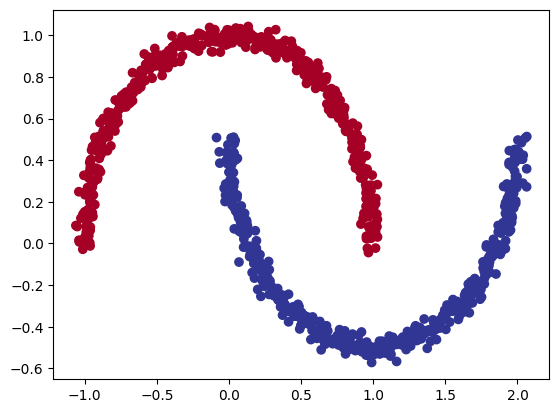

In [22]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Visualization of the data

In [23]:
X.shape, y.shape

((1000, 2), (1000,))

X is a 2d tensor (coordinates) y is just a 1d tensor, i.e. vector


In [24]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-0.00933187  0.39098105] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [25]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

Convert tensors into floats

In [26]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

80 20 split

In [38]:
# 1. Construct a model class that subclasses nn.Module
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)
# 4. Create an instance of the model and send it to target device
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

Create the model

In [39]:
# Replicate MoonModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Create the layers

In [40]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [41]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [42]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1483],
        [-0.4716],
        [-0.1092],
        [-0.5215],
        [-0.2247]], device='cuda:0', grad_fn=<SliceBackward0>)

In [44]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.28595, Accuracy: 85.12% | Test loss: 0.30140, Test acc: 85.50%
Epoch: 10 | Loss: 0.28046, Accuracy: 85.25% | Test loss: 0.29472, Test acc: 86.00%
Epoch: 20 | Loss: 0.27570, Accuracy: 85.50% | Test loss: 0.28884, Test acc: 86.50%
Epoch: 30 | Loss: 0.27153, Accuracy: 85.88% | Test loss: 0.28359, Test acc: 87.00%
Epoch: 40 | Loss: 0.26785, Accuracy: 86.12% | Test loss: 0.27890, Test acc: 87.00%
Epoch: 50 | Loss: 0.26459, Accuracy: 86.50% | Test loss: 0.27470, Test acc: 87.50%
Epoch: 60 | Loss: 0.26169, Accuracy: 86.75% | Test loss: 0.27092, Test acc: 87.50%
Epoch: 70 | Loss: 0.25911, Accuracy: 87.00% | Test loss: 0.26753, Test acc: 87.50%
Epoch: 80 | Loss: 0.25682, Accuracy: 87.25% | Test loss: 0.26450, Test acc: 87.50%
Epoch: 90 | Loss: 0.25479, Accuracy: 87.38% | Test loss: 0.26177, Test acc: 88.00%


helper_functions.py already exists, skipping download


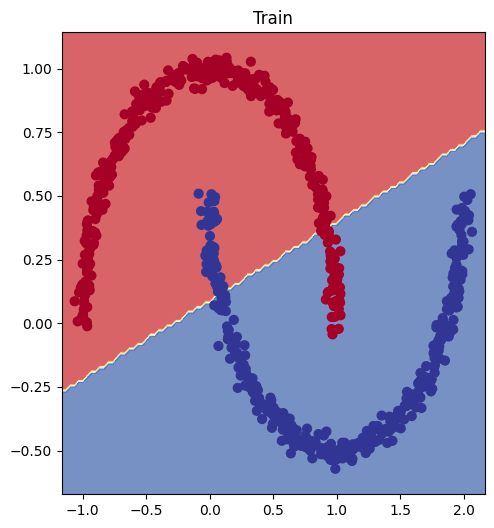

In [48]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
